In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load and preprocess the CIFAR-10 dataset
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

100%|██████████| 170M/170M [00:03<00:00, 43.3MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
# Load pre-trained ResNet-18 model
import torchvision.models as models

model = models.resnet18(pretrained=True)

# Modify the final layer for CIFAR-10
num_classes = 10
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

# Train the model
def train(model, trainloader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        scheduler.step()
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(trainloader):.4f}")

def evaluate(model, testloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Accuracy: {100 * correct / total:.2f}%")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 146MB/s]


In [ ]:
# Function to create a random patch
def create_patch(patch_size=(3, 3)):
    patch = torch.randn(3, *patch_size, requires_grad=True, device=device)
    return patch

# Function to apply the patch to images
def place_patch(img, patch):
    batch_size, _, h, w = img.size()
    ph, pw = patch.size(1), patch.size(2)
    for i in range(batch_size):
        x_offset = torch.randint(0, h - ph + 1, (1,)).item()
        y_offset = torch.randint(0, w - pw + 1, (1,)).item()
        img[i, :, x_offset:x_offset+ph, y_offset:y_offset+pw] = patch
    return img

# Training function for adversarial patch
def patch_training_step(model, patch, target_class=None, dataloader=None, optimizer=None, criterion=None):
    model.train()
    total_loss = 0
    for images, _ in dataloader:
        images = images.to(device)
        optimizer.zero_grad()
        patched_images = place_patch(images, patch)
        outputs = model(patched_images)
        if target_class is not None:
            labels = torch.full((images.size(0),), target_class, dtype=torch.long, device=device)
        else:
            labels = torch.randint(0, 10, (images.size(0),), device=device)  # Random class for untargeted attack
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(dataloader)

# Function to train the adversarial patch
def train_adversarial_patch(model, patch, target_class=None, num_epochs=10):
    patch_optimizer = optim.Adam([patch], lr=0.01)
    criterion = nn.CrossEntropyLoss()
    for epoch in range(num_epochs):
        loss = patch_training_step(model, patch, target_class, trainloader, patch_optimizer, criterion)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss:.4f}")

# Function to evaluate the success rate of the adversarial patch
def evaluate_patch_success_rate(model, patch, dataloader):
    model.eval()
    successful_attacks = 0
    total_samples = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            patched_images = place_patch(images.clone(), patch)
            outputs = model(patched_images)
            _, predicted = outputs.max(1)

            # Count successful untargeted attacks (where prediction differs from true label)
            successful_attacks += (predicted != labels).sum().item()
            total_samples += labels.size(0)

    success_rate = 100 * successful_attacks / total_samples
    print(f"Untargeted Attack Success Rate: {success_rate:.2f}%")
    return success_rate

# Function to visualize the patch
def visualize_patch(patch):
    patch = patch.detach().cpu().numpy()
    patch = np.clip((patch - patch.min()) / (patch.max() - patch.min()), 0, 1)

    plt.figure(figsize=(2, 2))
    plt.imshow(np.transpose(patch, (1, 2, 0)))  # [C, H, W] -> [H, W, C]
    plt.title("Adversarial Patch")
    plt.axis('off')
    plt.show()

# Function to visualize misclassified patched images
def visualize_misclassified_patched_images(model, patch, dataloader, classes, num_examples=5):
    model.eval()
    examples_shown = 0
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        patched_images = place_patch(images.clone(), patch)
        with torch.no_grad():
            original_preds = model(images).argmax(dim=1)
            patched_preds = model(patched_images).argmax(dim=1)
        for i in range(images.size(0)):
            if original_preds[i] == labels[i] and patched_preds[i] != labels[i]:
                original_image = (images[i].cpu().detach().numpy().transpose(1, 2, 0) * 0.5) + 0.5
                patched_image = (patched_images[i].cpu().detach().numpy().transpose(1, 2, 0) * 0.5) + 0.5

                fig, axes = plt.subplots(1, 2, figsize=(4, 4))
                axes[0].imshow(np.clip(original_image, 0, 1))
                axes[0].set_title(f"Original Image\nTrue Label: {classes[labels[i].item()]}\nPredicted: {classes[original_preds[i].item()]}")

                axes[1].imshow(np.clip(patched_image, 0, 1))
                axes[1].set_title(f"Image with Adversarial Patch\nTrue Label: {classes[labels[i].item()]}\nPredicted: {classes[patched_preds[i].item()]}")

                plt.show()
                examples_shown += 1
                if examples_shown >= num_examples:
                    return


Training for patch size: (3, 3)
Epoch 1/20, Loss: 2.6534
Epoch 2/20, Loss: 2.6544
Epoch 3/20, Loss: 2.6513
Epoch 4/20, Loss: 2.6508
Epoch 5/20, Loss: 2.6546
Epoch 6/20, Loss: 2.6532
Epoch 7/20, Loss: 2.6555
Epoch 8/20, Loss: 2.6608
Epoch 9/20, Loss: 2.6489
Epoch 10/20, Loss: 2.6453
Epoch 11/20, Loss: 2.6565
Epoch 12/20, Loss: 2.6435
Epoch 13/20, Loss: 2.6473
Epoch 14/20, Loss: 2.6495
Epoch 15/20, Loss: 2.6590
Epoch 16/20, Loss: 2.6547
Epoch 17/20, Loss: 2.6527
Epoch 18/20, Loss: 2.6480
Epoch 19/20, Loss: 2.6453
Epoch 20/20, Loss: 2.6528
Visualizing patch of size (3, 3)


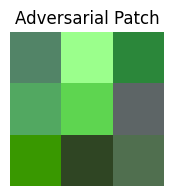

Untargeted Attack Success Rate: 91.00%


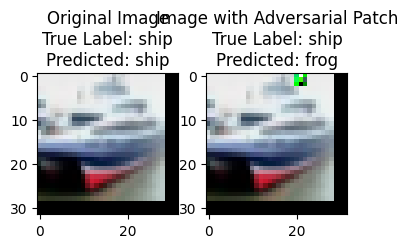

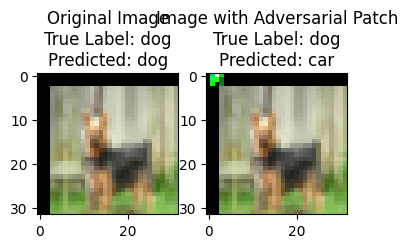

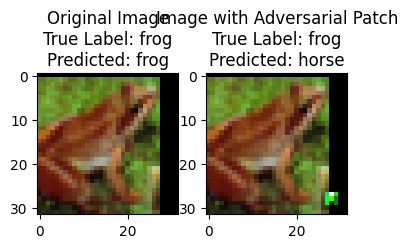

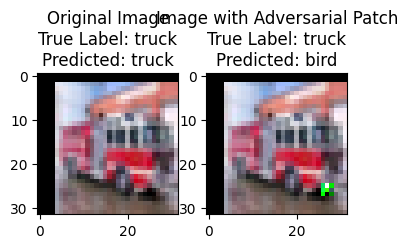

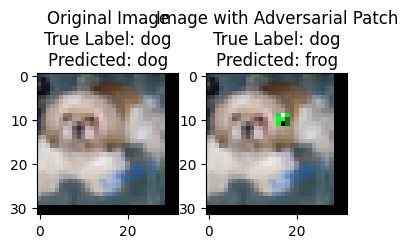


Training for patch size: (5, 5)
Epoch 1/20, Loss: 2.6536
Epoch 2/20, Loss: 2.6563
Epoch 3/20, Loss: 2.6515
Epoch 4/20, Loss: 2.6540
Epoch 5/20, Loss: 2.6494
Epoch 6/20, Loss: 2.6503
Epoch 7/20, Loss: 2.6486
Epoch 8/20, Loss: 2.6479
Epoch 9/20, Loss: 2.6451
Epoch 10/20, Loss: 2.6453
Epoch 11/20, Loss: 2.6417
Epoch 12/20, Loss: 2.6473
Epoch 13/20, Loss: 2.6412
Epoch 14/20, Loss: 2.6442
Epoch 15/20, Loss: 2.6427
Epoch 16/20, Loss: 2.6364
Epoch 17/20, Loss: 2.6379
Epoch 18/20, Loss: 2.6448
Epoch 19/20, Loss: 2.6406
Epoch 20/20, Loss: 2.6411
Visualizing patch of size (5, 5)


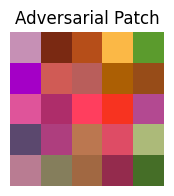

Untargeted Attack Success Rate: 91.17%


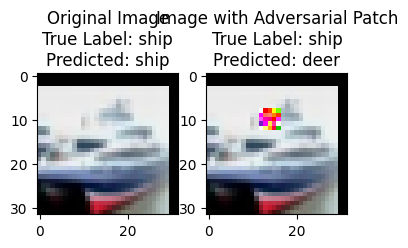

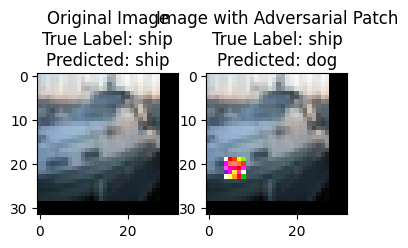

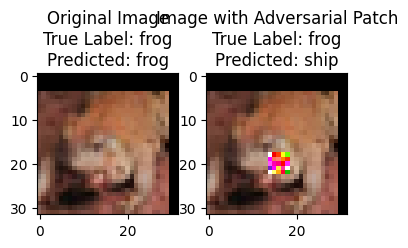

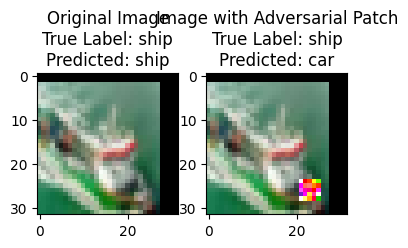

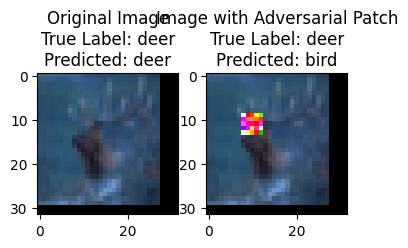


Training for patch size: (7, 7)
Epoch 1/20, Loss: 2.6581
Epoch 2/20, Loss: 2.6522
Epoch 3/20, Loss: 2.6530
Epoch 4/20, Loss: 2.6451
Epoch 5/20, Loss: 2.6546
Epoch 6/20, Loss: 2.6417
Epoch 7/20, Loss: 2.6441
Epoch 8/20, Loss: 2.6473
Epoch 9/20, Loss: 2.6429
Epoch 10/20, Loss: 2.6442
Epoch 11/20, Loss: 2.6438
Epoch 12/20, Loss: 2.6462
Epoch 13/20, Loss: 2.6402
Epoch 14/20, Loss: 2.6407
Epoch 15/20, Loss: 2.6436
Epoch 16/20, Loss: 2.6419
Epoch 17/20, Loss: 2.6394
Epoch 18/20, Loss: 2.6330
Epoch 19/20, Loss: 2.6379
Epoch 20/20, Loss: 2.6378
Visualizing patch of size (7, 7)


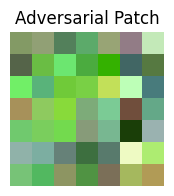

Untargeted Attack Success Rate: 90.73%


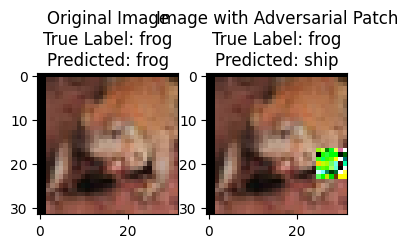

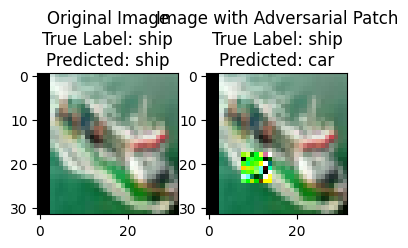

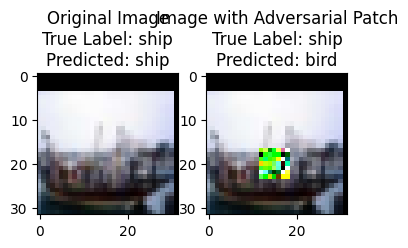

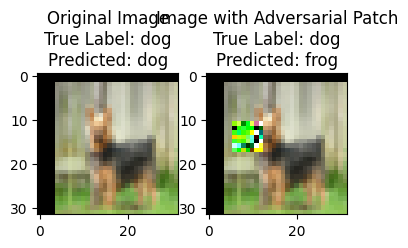

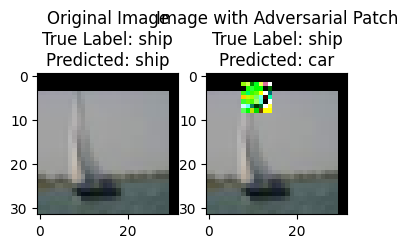


Training for patch size: (16, 16)
Epoch 1/20, Loss: 2.6401
Epoch 2/20, Loss: 2.6324
Epoch 3/20, Loss: 2.6418
Epoch 4/20, Loss: 2.6397
Epoch 5/20, Loss: 2.6293
Epoch 6/20, Loss: 2.6310
Epoch 7/20, Loss: 2.6291
Epoch 8/20, Loss: 2.6319
Epoch 9/20, Loss: 2.6246
Epoch 10/20, Loss: 2.6321
Epoch 11/20, Loss: 2.6187
Epoch 12/20, Loss: 2.6180
Epoch 13/20, Loss: 2.6145
Epoch 14/20, Loss: 2.6148
Epoch 15/20, Loss: 2.6188
Epoch 16/20, Loss: 2.6177
Epoch 17/20, Loss: 2.6097
Epoch 18/20, Loss: 2.6123
Epoch 19/20, Loss: 2.6162
Epoch 20/20, Loss: 2.6055
Visualizing patch of size (16, 16)


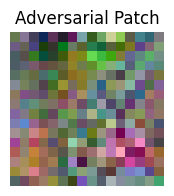

Untargeted Attack Success Rate: 90.51%


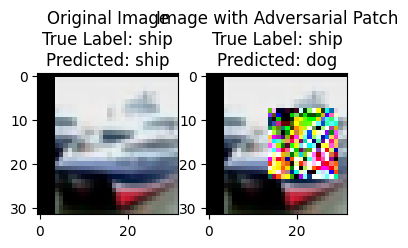

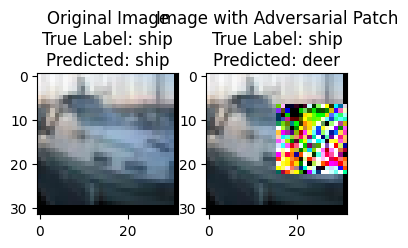

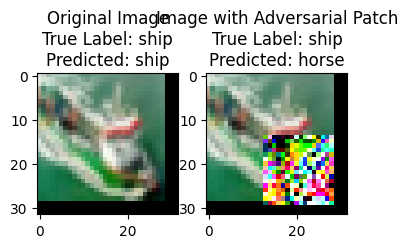

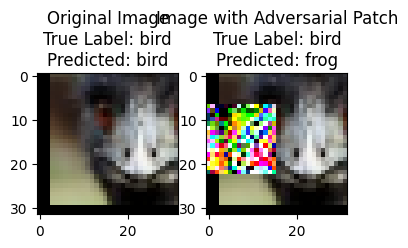

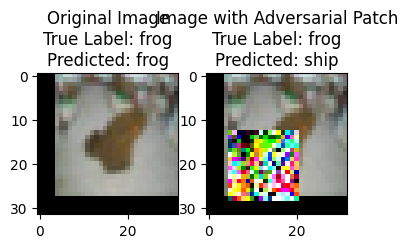

In [ ]:
# CIFAR-10 class names
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Different patch sizes
patch_sizes = [(3, 3), (5, 5), (7, 7), (16, 16)]

# Train and evaluate patches of different sizes
for patch_size in patch_sizes:
    print(f"\nTraining for patch size: {patch_size}")
    patch = create_patch(patch_size)
    train_adversarial_patch(model, patch, target_class=None, num_epochs=20)

    # Save the patch
    torch.save(patch, f'adversarial_patch_{patch_size[0]}x{patch_size[1]}.pth')

    # Visualize the patch
    print(f"Visualizing patch of size {patch_size}")
    visualize_patch(patch)

    # Evaluate attack success rate
    evaluate_patch_success_rate(model, patch, testloader)

    # Visualize misclassified examples with the adversarial patch
    visualize_misclassified_patched_images(model, patch, testloader, classes, num_examples=5)